# An Introduction to JAX

[JAX](https://jax.readthedocs.io/en/latest/index.html) is an advanced scientific computing library for Python. At a very crude level, it's an alternative to Numpy that provides auto-differentiation and Xcellerated Linear Algebra (XLA) that can run on GPUs. Unlike Tensorflow and PyTorch, it only operates within a functional programming paradism, where all functions must be pure (enforce referential transparency). It is developed and maintained by Google.

## Imports

In [40]:
from typing import List, Tuple

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## JAX as Accelerated Numpy

JAX implements the Numpy API and more-often-than-not it can be used as a stand-in replacement.

In [2]:
x = jnp.array([1., 2., 3., 4., 5.])
x

DeviceArray([1., 2., 3., 4., 5.], dtype=float32)

There are, however, a few subtle differences. Firstly, the output is of type `DeviceArray`, which represents an array on a particular device (CPU, GPU, etc.). To convert this back to raw Numpy, use the `to_py` method.

In [3]:
x.to_py()

array([1., 2., 3., 4., 5.], dtype=float32)

Secondly, when a JAX function is called, the corresponding operation is dispatched to an accelerator to be computed asynchronously when possible. The returned array is therefore not necessarily ‘filled in’ as soon as the function returns. Thus, if we don’t require the result immediately, the computation won’t block Python execution. If the computation is required - e.g., when using the `block_until_ready` method, converting to a Numpy array or printing a result, then the call to the computation will be blocking. See [Asynchronous dispatch](https://jax.readthedocs.io/en/latest/async_dispatch.html#asynchronous-dispatch) in the JAX docs.

In [4]:
y = jnp.dot(x, x).block_until_ready()

## Differentiation

Auto-differentiation is Jax follows a functional programming paradigm. For example, consider the following example from PyTorch,

```python
import torch

x = torch.tensor(2., requires_grad=True)
y = x ** 2
y.backward()
x.grad

# tensor(4.)
```

This pattern is imperative and functional. In Jax this would be implemented as follows,

In [22]:
def x_squared(x: jnp.DeviceArray) -> jnp.DeviceArray:
    return x ** 2


x_squared_dx = jax.grad(x_squared)
x_squared_dx(jnp.array(2.))

DeviceArray(4., dtype=float32, weak_type=True)

We can easily extrapolate this example to a simple gradient descent problem.

100%|██████████| 50/50 [00:00<00:00, 1355.68it/s]

x = 2.00


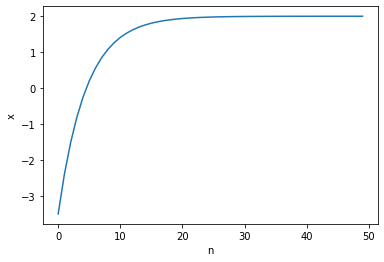

In [41]:
def f(x: jnp.DeviceArray) -> jnp.DeviceArray:
    return (x - 2) ** 2


n_iterations = 50
eta = 0.1

x = jnp.array(-3.5)
x_hist: List[Tuple[int, float]] = []

for n in tqdm(range(n_iterations)):
    x_hist.append((n, x.tolist()))
    x -= eta *jax.grad(f)(x)

print(f"x = {x:.2f}")
_ = sns.lineplot(y="x", x="n", data=pd.DataFrame(x_hist, columns=["n", "x"]))

Which is simpler than the PyTorch equivalent,

```python
def f(x: torch.Tensor) -> torch.Tensor:
    return (x - 2) ** 2


n_iterations = 50
eta = 0.1

x = torch.tensor([-3.5], requires_grad=True)
x_hist: List[Tuple[int, float]] = []

for n in tqdm(range(n_iterations)):
    x_hist.append((n, x.detach().numpy()[0]))
    f(x).backward()
    x.data -= eta * x.grad
    x.grad.zero_()

print(f"x = {x.detach().numpy()[0]:.2f}")
_ = sns.lineplot(y="x", x="n", data=pd.DataFrame(x_hist, columns=["n", "x"]))
```

We can extended this to more complex vector-valued functions, where the `grad` operator will behave like the $\nabla$ operator in formal calculus.

In [43]:
def sum_of_squares(x: jnp.DeviceArray) -> jnp.DeviceArray:
  return jnp.sum(x**2)


sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.array([1., 2., 3., 4., 5.])
print(f"sum-of-squares = {sum_of_squares(x)}")
print(f"d sum-of-squares / dx = {sum_of_squares_dx(x)}")

sum-of-squares = 55.0
d sum-of-squares / dx = [ 2.  4.  6.  8. 10.]


By default, the `grad` operator will only compute derivatives relative to a function's first argument. To extend this to other arguments we use `argnums`.

In [44]:
def sum_of_squared_errors(x: jnp.DeviceArray, y: jnp.DeviceArray) -> jnp.DeviceArray:
    return jnp.sum((x - y) ** 2)

sum_of_squared_errors_dx = jax.grad(sum_of_squared_errors, argnums=(0, 1))

x = jnp.array([1., 2., 3., 4., 5.])
print(f"sum-of-squared-errors = {sum_of_squared_errors(x, x*1.1)}")
print(f"d sum-of-squared-errors / dx = {sum_of_squared_errors_dx(x, x*1.1)[0]}")
print(f"d sum-of-squared-errors / dy = {sum_of_squared_errors_dx(x, x*1.1)[1]}")

sum-of-squared-errors = 0.5500001907348633
d sum-of-squared-errors / dx = [-0.20000005 -0.4000001  -0.6000004  -0.8000002  -1.        ]
d sum-of-squared-errors / dy = [0.20000005 0.4000001  0.6000004  0.8000002  1.        ]
